## Processing functions for hyperspectral PiFM data cubes

There are two goals for processing hyperspectral polymer-blend data cubes: 1) Decompose the image into the component ground-truth spectra of the polmyers, and 2) Construct and image which encodes information about the coefficients of each polymer blend at each pixel.

First, we will utilize Non-Negative Matrix Factorization (NMF) to decompose the data cube into its component spectra. As explained earlier, we will get both the component spectra (the H matrix) and a matrix of coefficients (the W matrix). We will use the W matrix to build a normalized image of the polymer coefficients and then construct a threshold mask to spatially demonstrate the mixing of the polymers in the blend.

Import I/O and plotting modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Import custom modules for hyperspectral datacube processing

In [10]:
from processing import *

Import an image that has been sampled and is now 64x64x1128

In [13]:
im = np.load('test_image.npy')

Perform NMF on the datacube. We will use a customized function adapted from sklearn.decomposition.NMF and we will obtain an H matrix (the components) and a W matrix (the coefficients).

In [16]:
W_mat, H_mat = run_nmf(im, comps=2)

Lets take a look at the function we just performed

In [21]:
print(run_nmf.__doc__)


    Performs NMF analysis on a give image.

    Processing wrapper for NMF on 3D data cubes for hyperspectral images with a given number of components.

    Parameters
    ----------
    im : numpy array
        3D data cube of hyperspectral image
    comps : integer
        Number of components that NMF will try to identify
    solver : string (optional)
        Either 'cd' or 'mu' for coordinate descent or multiplicative update; default 'cd'
    tol : float (optional)
        Tolerance factor; adjust to smaller if analysis requires more precision; default 1e-5
    max_iter : integer (optional)
        Number of iterations NMF algorithm will attempt to separate components; adjust as necessary for attempts and/or time constraints; default int(1e6)
    l1_ratio : float (optional)
        Algorithm step size factor; adjust to smaller or larger to change fitting/overfitting; default 0.2
    alpha : float (optional)
        Algorithm step size factor; default 1e-3
    verbose : Boolean (o

Now, lets visualize the coefficients from the W matrix. We know from the check_comps function which set of coefficients applies to which polmyer. In this case, DPPDTT is the 0th element and PS is the 1st element.

First we need to reshape the W matrix as it was returned in a flattened form.

In [25]:
coeffs = W_mat.reshape(64,64,2)

Text(0.5, 1.0, 'Coefficients of PS')

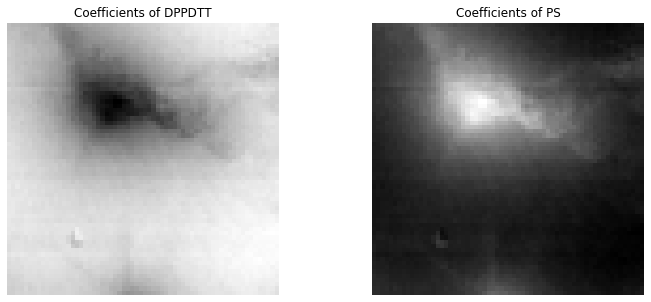

In [27]:
figs, axes = plt.subplots(ncols=2, figsize=(12, 5))

for ax in axes:
    ax.axis('off')
    
axes[0].imshow(coeffs[:,:,0], cmap='gray')
axes[0].set_title('Coefficients of DPPDTT')

axes[1].imshow(coeffs[:,:,1], cmap='gray')
axes[1].set_title('Coefficients of PS')

As we would expect, the coefficient images are basically the opposite of each other. However, we can see that they don't exactly add up to 1.

In [32]:
print('DPPDTT slice = {}'.format(coeffs[13,13,0]))
print('PS slice = {}'.format(coeffs[13,13,1]))
print('And the sum is : {}'.format(coeffs[13,13,0] + coeffs[13,13,1]))

DPPDTT slice = 0.6387765926472811
PS slice = 0.26979543355381513
And the sum is : 0.9085720262010963


We need to normalize the coefficient image relative to one polmyer - we will use DPPDTT (integer value 0).

We will also revert to using the W_mat instead of the reshaped coeffs because the normalization function reshapes the
W matrix for us!

In [34]:
norm_im = norm_W(W_mat, 0)

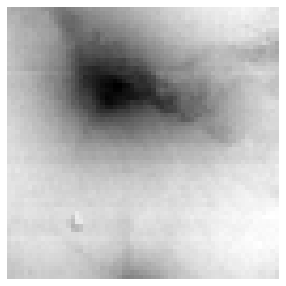

In [44]:
fig, ax = plt.subplots(figsize=(5,5))

ax.axis('off')
ax.imshow(norm_im, cmap='gray')

With this normalized image, we can create a thresholded mask of the image to visualize on an original slice of the image the parts that are over a certain percentage DPPDTT

We will use a custom function that takes as input the normalized image and a value to threshold.

In [45]:
mask = mask_im(norm_im, 0.5)

Lets visualize the mask along with the masked overlay on an original image slice at wavenumber 555

Text(0.5, 1.0, 'Masked Image')

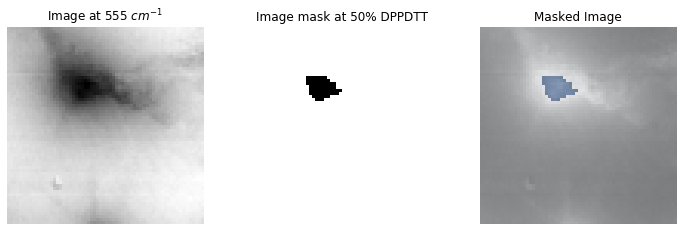

In [68]:
figs, axes = plt.subplots(ncols=3, figsize=(12, 5))

for ax in axes:
    ax.axis('off')

axes[0].imshow(im[:,:,555-750], cmap='gray')
axes[0].set_title(r'Image at 555 $cm^{-1}$')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Image mask at 50% DPPDTT')

axes[2].imshow(im[:,:,55-750], cmap='gray')
axes[2].imshow(mask, cmap='Blues_r', alpha=0.5)
axes[2].set_title('Masked Image')


## Image visualization methods

In this section, we will visualize individual normalized slices from a datacube and use threshold masks to compute the area fraction of one polymer in the blend for an image slice.

Import the necessary visualization modules

In [75]:
from visualization import *

Let's first visualize the datacube at several different wavenumbers

Text(0.5, 1.0, 'Image at 1400 $cm^{-1}$')

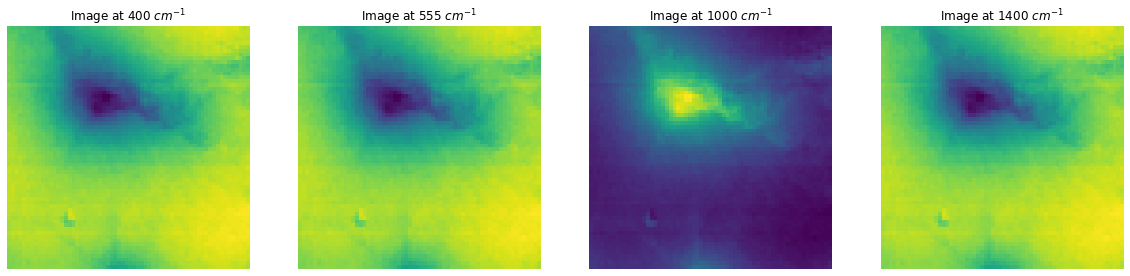

In [76]:
figs, axes = plt.subplots(ncols=4, figsize=(20,5))
im400 = Wav_2_Im(im, 400)
im555 = Wav_2_Im(im, 555)
im1000 = Wav_2_Im(im, 1000)
im1400 = Wav_2_Im(im, 1400)

for ax in axes:
    ax.axis('off')

axes[0].imshow(im400)
axes[0].set_title(r'Image at 400 $cm^{-1}$')

axes[1].imshow(im555)
axes[1].set_title(r'Image at 555 $cm^{-1}$')

axes[2].imshow(im1000)
axes[2].set_title(r'Image at 1000 $cm^{-1}$')

axes[3].imshow(im1400)
axes[3].set_title(r'Image at 1400 $cm^{-1}$')


We can also compute the area fraction of the image that is a certain percentage (or more) of DPPDTT and a variety of thresholds

In [77]:
props, ims, fracs = AreaFraction(im555, norm_im, 64)

Lets see the masks

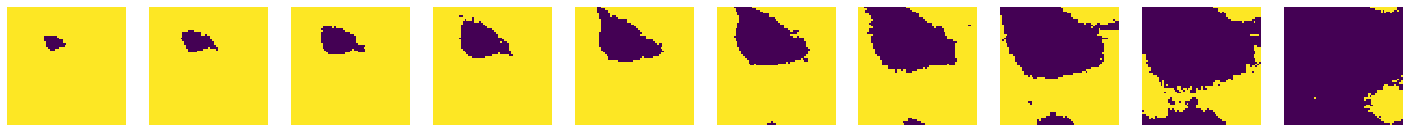

In [91]:
figs, axes = plt.subplots(ncols=10, figsize=(25,3))

for i in range(ims.shape[2]):
        axes[i].axis('off')
        axes[i].imshow(ims[:,:,i])


Now, lets plot the area fraction as a function of the threshold value

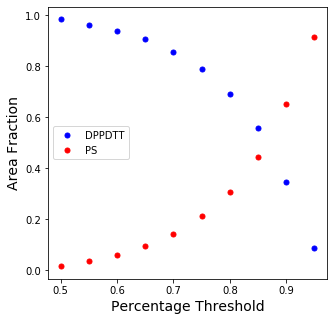

In [92]:
sum_fracs = []
for i in range(len(fracs)):
    sum_fracs.append(np.sum(fracs[i]))

figs, axes = plt.subplots( figsize=(5,5))
percents = np.round(np.arange(0.5, 1.0, 0.05),2)

axes.plot(percents, np.array(sum_fracs), linestyle="None", marker="o", markersize=5, color='b', label="DPPDTT")
axes.plot(percents, 1-np.array(sum_fracs), linestyle="None", marker="o", markersize=5, color='r', label="PS")
axes.set_ylabel('Area Fraction', fontsize=14)
axes.set_xlabel('Percentage Threshold', fontsize=14)
axes.legend()